# Gibbs Privacy for Federated Learning

### Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tqdm
import copy
import json
from joblib import Parallel, delayed
import os

#### Data Generation

We generate a hierarchical mixture model consisting of 2 clusters. We follow the same procedure as in the paper.

$$
\begin{align*}
& \theta^{\text{S}}_r \sim \mathcal{N}(\bar{\theta}, \bar{\Sigma}), \quad r \in \{1,2\}\\
& \theta^a_r \sim \mathcal{N}(\theta^{\text{S}}_r, \Sigma), \quad r \in \{1,2\}, a \in \{1, \ldots, N\}\\
& x^a_i \sim \omega_a \mathcal{N}(\theta^a_1, \Sigma_1) + (1 - \omega_a) \mathcal{N}(\theta^a_2 , \Sigma_2),\\
& \quad a \in \{1, \ldots, N\}, i \in \{1,\ldots,n_a\},
\end{align*}
$$

The weights $\omega_a$ of the mixture model are considered known by each agent $a$. To generate data we set $\theta^\text{S}_1 = - \theta^\text{S}_2 = (0.5,0.5)$, and sample $\theta^a \in \mathbb{R}^2$ according to the conditional prior distributions in \eqref{eq:mixmodel} with covariance 
\begin{equation*}
    \Sigma = \begin{pmatrix} 0.01 & 0  \\ 0 & 0.01\end{pmatrix}.
\end{equation*}
We set the number of agents $A = 10$. For each agent, we sample $\omega_a \sim \mathcal{U}(0,1)$ once, draw the number of observations for each agent, $n_a$, uniformly between $[80, 100]$, and generate the corresponding data $x^a_i$ with 
\begin{equation*}
\Sigma_1 = \begin{pmatrix} 0.05 & 0  \\ 0 & 0.02\end{pmatrix},
\Sigma_2 = \begin{pmatrix} 0.02 & 0  \\ 0 & 0.04\end{pmatrix}.
\end{equation*} 
When we run our algorithm, we choose a large variance prior for the server parameters by taking $\bar{\theta} = (0,0)$ and $\bar{\Sigma} = \begin{pmatrix} 5 & 0  \\ 0 & 5\end{pmatrix}$.

For our experiments we choose $u^a \sim p(u|n_a)$ with $p(u|n_a) = \prod_{i=1}^{n_a}(1-\alpha)^{u_i}\alpha^{1-u_i}$ for $u_i \in \{0,1\}$ representing $n_a$ independent Bernoulli trials. For each simulation we produce reference samples from the true posterior by using a standard Gibbs sampler (i.e. $\alpha = 0$) running for a large number of iterations $T= 50,000$. We test our Bayesian hierarchical federated learning approach with the values $\alpha = (\frac{1}{n_a}= 0.0125,  0.12, 0.25, 0.5)$ using $T=4,000$ iterations each time and then assess the impact of $\alpha$ on convergence to the true posterior. 


In [3]:
simulation_name = "Simulation_A" #### modify the name of the simulation here
save_KL = True
save_all = True
results_path = 'results' #### modify the path to the results here

In [4]:
nAgents = 10
thetaS1Theo = np.array([0.5, 0.5])
thetaS2Theo = np.array([-0.5, -0.5])
Sigma = np.diag([0.1, 0.1])
thetaSBar = np.zeros(2)
bigSigma = np.diag([5,5])
sigmaA1 = np.diag([0.05, 0.02])
sigmaA2 = np.diag([0.02, 0.04])


### we generate the data according to the hierarchical model

def create_data():
    persPerAgents = np.random.randint(80,100,nAgents) ## generate a random number of data per nAgents
    nPers = np.sum(persPerAgents)
    propAgents = np.random.beta(2,2,nAgents) ## generate the proportion of each mode
    thetaA1Theo = np.random.multivariate_normal(thetaS1Theo,Sigma , nAgents)
    thetaA2Theo = np.random.multivariate_normal(thetaS2Theo, Sigma, nAgents)
    data = {}
    data['nAgents'] = nAgents
    data['persPerAgents'] = persPerAgents.tolist()
    data['propAgents'] = propAgents.tolist()
    data['thetaS1Theo'] = thetaS1Theo.tolist()
    data['thetaS2Theo'] = thetaS2Theo.tolist()
    data['Sigma'] = Sigma.tolist()
    data['thetaSBar'] = thetaSBar.tolist()
    data['bigSigma'] = bigSigma.tolist()
    data['thetaA1Theo'] = thetaA1Theo.tolist()
    data['thetaA2Theo'] = thetaA2Theo.tolist()
    data['sigmaA1'] = sigmaA1.tolist()
    data['sigmaA2'] = sigmaA2.tolist()
    
    for agent in range(nAgents):
        data[f'Agent {agent}'] =  np.zeros((persPerAgents[agent],2))
        for pers in range(persPerAgents[agent]):
            if np.random.uniform(0,1) < propAgents[agent]:
                data[f'Agent {agent}'][pers,:] = np.random.multivariate_normal(thetaA1Theo[agent], sigmaA1)
            else:
                data[f'Agent {agent}'][pers,:] = np.random.multivariate_normal(thetaA2Theo[agent], sigmaA2)

    outlier = np.array([-1.5,-1.5])
    data['outlier'] = outlier.reshape(1,2)
    return data

data = create_data()
dataOutlier = copy.deepcopy(data)
dataOutlier['Agent 0'][0,:] = data['outlier']

In [7]:
## Save the data
def save_data(data, results_path, simulation_name):
    if not os.path.exists(results_path):
        os.makedirs(results_path)
        print(f"Folder '{results_path}' created.")
    if not os.path.exists(f"{results_path}/{simulation_name}"):
        os.makedirs(f"{results_path}/{simulation_name}")
        print(f"Folder '{results_path}/{simulation_name}' created.")
    else:
        data_save = copy.deepcopy(data)
        for key,values in data_save.items():
            if type(values) == np.ndarray:
                data_save[key] = values.tolist()
        with open(f"{results_path}/{simulation_name}/data.json", "w") as f:
            json.dump(data_save, f)

def load_data(results_path, simulation_name):
    if not os.path.exists(f"{results_path}/{simulation_name}/data.json"):
        raise FileExistsError(f"File '{results_path}/{simulation_name}/data.json' doesn't exist.")
    else:
        with open(f'{results_path}/{simulation_name}/data.json', "r") as f:
            loaded_dict = json.load(f)
        data = {}
        for key, values in loaded_dict.items():
            data[key] = np.array(values)
        return data

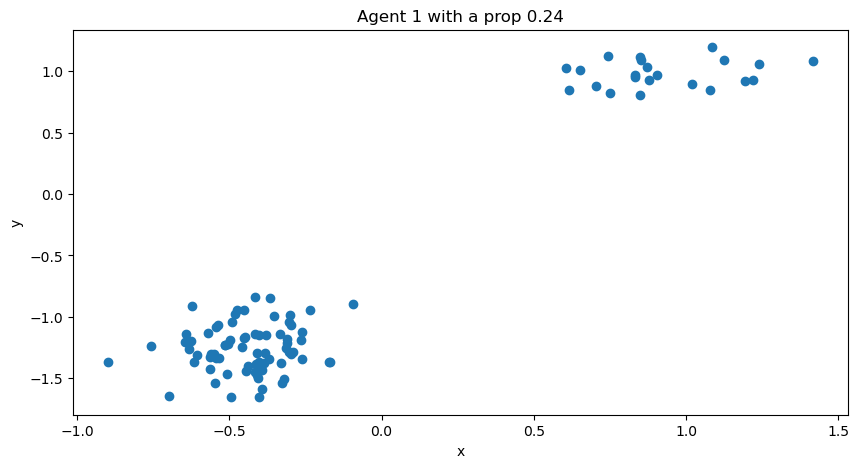

In [8]:
#### display the data for agent 1
propAgents = data['propAgents']
agent1 = 'Agent 0'
plt.figure(figsize=(10, 5))
plt.plot(data[agent1][:, 0], data[agent1][:, 1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Agent 1 with a prop {propAgents[0]:.2f}')
plt.show()

#### Draws for simulations

In [9]:
def posterior_theta(X,w,thetaA1Agent,thetaA2Agent,thetaS1,thetaS2):
    if thetaA1Agent @ np.ones(2) < thetaA2Agent @ np.ones(2):
        thetaA1Agent, thetaA2Agent = thetaA2Agent, thetaA1Agent
    p1 = w * stats.multivariate_normal.pdf(X,thetaA1Agent,sigmaA1)/(w * stats.multivariate_normal.pdf(X,thetaA1Agent,sigmaA1) + (1-w)* stats.multivariate_normal.pdf(X,thetaA2Agent,sigmaA2))
    latent = np.random.binomial(1, p1)
    X1 = X[latent==1]
    X2 = X[latent==0]

    Sigmaw1 = np.linalg.inv(np.linalg.inv(sigmaA1)*len(X1)+ np.linalg.inv(Sigma))
    Sigmaw2 = np.linalg.inv(np.linalg.inv(sigmaA2)*len(X2) + np.linalg.inv(Sigma))

    M1 = Sigmaw1 @ (np.linalg.inv(sigmaA1) @np.sum(X1,axis=0) + np.linalg.inv(Sigma) @ thetaS1 )
    M2 = Sigmaw2 @ (np.linalg.inv(sigmaA2) @np.sum(X2,axis=0) + np.linalg.inv(Sigma) @ thetaS2 )
    
    thetaA1Agent = np.random.multivariate_normal(M1, Sigmaw1)
    thetaA2Agent = np.random.multivariate_normal(M2, Sigmaw2)

    return thetaA1Agent, thetaA2Agent

def Gibbs_server(thetaA1,thetaA2):
    Sigmaw1 = np.linalg.inv(np.linalg.inv(Sigma)*len(thetaA1)+ np.linalg.inv(bigSigma))
    Sigmaw2 = np.linalg.inv(np.linalg.inv(Sigma)*len(thetaA2) + np.linalg.inv(bigSigma))
    M1 = Sigmaw1 @ (np.linalg.inv(Sigma) @np.sum(thetaA1,axis=0) + np.linalg.inv(bigSigma) @ thetaSBar )
    M2 = Sigmaw2 @ (np.linalg.inv(Sigma) @np.sum(thetaA2,axis=0) + np.linalg.inv(bigSigma) @ thetaSBar )
    thetaS1 = np.random.multivariate_normal(M1, Sigmaw1)
    thetaS2 = np.random.multivariate_normal(M2, Sigmaw2)
    if thetaS1 @ np.ones(2) < thetaS2 @ np.ones(2):
        thetaS1, thetaS2 = thetaS2, thetaS1
    return thetaS1, thetaS2

def local_likelihood(dataAgent, w, thetaA1Agent , thetaA2Agent):
    return np.sum(np.log(w * stats.multivariate_normal.pdf(dataAgent, thetaA1Agent,sigmaA1) + (1 - w)* stats.multivariate_normal.pdf(dataAgent, thetaA2Agent,sigmaA2)))

def MH_within_Gibbs_agent_perturbed(X,alpha,w,thetaA1Agent,thetaA2Agent,thetaS1,thetaS2):
    u = np.random.binomial(1, 1-alpha, len(X))
    l = np.random.binomial(1, w, len(X))
    fakeX1 = np.random.multivariate_normal(thetaA1Agent, sigmaA1, len(X))
    fakeX2 = np.random.multivariate_normal(thetaA2Agent, sigmaA2, len(X))
    fakeX = np.zeros((len(X),2))
    fakeX[l==0] = fakeX1[l==0]
    fakeX[l==1] = fakeX2[l==1]
    thetaA1_test,thetaA2_test = posterior_theta(X[u==1],w,thetaA1Agent, thetaA2Agent, thetaS1,thetaS2)
    ratio = local_likelihood(X[u==0], w, thetaA1_test, thetaA2_test) + local_likelihood(fakeX[u==0],w,thetaA1_test, thetaA2_test) \
            - local_likelihood(X[u==0],w,thetaA1Agent, thetaA2Agent) -  local_likelihood(fakeX[u==0], w, thetaA1Agent, thetaA2Agent) 
    accept = 0
    if np.log(np.random.rand()) < ratio:
        accept = 1
        thetaA1Agent = thetaA1_test
        thetaA2Agent = thetaA2_test
    return thetaA1Agent, thetaA2Agent, accept


In [10]:
def sym_KL(sample1, sample2, bins=100, epsilon=1e-10):
    # Calculate the 2D histograms for both samples
    h1, xedges, yedges = np.histogram2d(sample1[:, 0], sample1[:, 1], bins=bins)
    h2, _, _ = np.histogram2d(sample2[:, 0], sample2[:, 1], bins=(xedges, yedges))

    # Normalize the histograms
    h1 /= np.sum(h1)
    h2 /= np.sum(h2)

    # Avoid division by zero by adding a small epsilon
    h1 = np.clip(h1, epsilon, None)
    h2 = np.clip(h2, epsilon, None)

    # Calculate the KL divergences in both directions
    kl1 = np.sum(h1 * np.log(h1 / h2))
    kl2 = np.sum(h2 * np.log(h2 / h1))

    # Calculate the symmetric KL divergence
    symmetric_kl = 0.5 * (kl1 + kl2)

    return symmetric_kl


def acceptance_rate(parameter_evolution):
    nAlphas, nRounds, nAgents, nDim = parameter_evolution.shape
    acceptance_rate = np.zeros((nAlphas, nAgents))
    for a in range(nAlphas):
        for agent in range(nAgents):
            different = (parameter_evolution[a,1:,agent,:] != parameter_evolution[a,:-1,agent,:])
            acceptance_rate[a,agent] = (np.sum(different[:,0], axis= 0)+1)/ nRounds

    return acceptance_rate

In [11]:
# Define the number of CPU cores you want to utilize
num_cores = os.cpu_count()  
print(f"Number of cores: {num_cores}")
nRounds = 8000
alphas_to_process = np.array([0.0125,0.05,0.12,0.25,0.5])
alphas = np.array([0.0125,0.05,0.12,0.25,0.5])

def process_true(data):
    thetaA1_evolution = np.zeros((2*nRounds,nAgents,2))
    thetaA2_evolution = np.zeros((2*nRounds,nAgents,2))
    thetaS1_evolution = np.zeros((2*nRounds,2))
    thetaS2_evolution = np.zeros((2*nRounds,2))
    thetaS1 = np.zeros(2)
    thetaS2 = np.zeros(2)
    thetaA1 = np.zeros((nAgents,2))
    thetaA2 = np.zeros((nAgents,2))

    for round in tqdm.tqdm(range(2*nRounds)):
        for agent in range(nAgents):
            name_agent = 'Agent ' + str(agent)
            w = data['propAgents'][agent]
            dataAgent = data[name_agent]
            thetaA1[agent],thetaA2[agent] = posterior_theta(dataAgent,w,thetaA1[agent],thetaA2[agent],thetaS1,thetaS2)
            thetaA1_evolution[round,agent] = thetaA1[agent]
            thetaA2_evolution[round,agent] = thetaA2[agent]
        thetaS1_evolution[round], thetaS2_evolution[round] = Gibbs_server(thetaA1_evolution[round,:] ,thetaA2_evolution[round,:])
        thetaS1 = thetaS1_evolution[round]
        thetaS2 = thetaS2_evolution[round]
    return (thetaA1_evolution, thetaA2_evolution, thetaS1_evolution, thetaS2_evolution)


def process_alpha(alpha, data):
    thetaA1_evolution_alpha = np.zeros((nRounds, nAgents, 2))
    thetaA2_evolution_alpha = np.zeros((nRounds, nAgents, 2))
    thetaS1_evolution_alpha = np.zeros((nRounds, 2))
    thetaS2_evolution_alpha = np.zeros((nRounds, 2))
    thetaA1 = np.zeros((nAgents, 2))
    thetaA2 = np.zeros((nAgents, 2))
    thetaS1 = np.zeros(2)
    thetaS2 = np.zeros(2)

    for round in tqdm.tqdm(range(nRounds)):
        for agent in range(nAgents):
            name_agent = 'Agent ' + str(agent)
            w = data['propAgents'][agent]
            dataAgent = data[name_agent]
            thetaA1[agent], thetaA2[agent], accept = MH_within_Gibbs_agent_perturbed(dataAgent, alpha, w, thetaA1[agent], thetaA2[agent], thetaS1, thetaS2)

        thetaA1_evolution_alpha[round] = thetaA1
        thetaA2_evolution_alpha[round] = thetaA2
        thetaS1, thetaS2 = Gibbs_server(thetaA1, thetaA2)
        thetaS1_evolution_alpha[round] = thetaS1
        thetaS2_evolution_alpha[round] = thetaS2
        
    return (thetaA1_evolution_alpha, thetaA2_evolution_alpha, thetaS1_evolution_alpha, thetaS2_evolution_alpha)


Number of cores: 12


To avoid saving all the data points, we can only save the KL distance between samples. This is all stored in the "dist\_to\_cvg" variable organised as suche :
$$ dist\_to\_cvg = [\theta_0^1, \dots , \theta_{A}^1, \theta_0^2 , \dots , \theta_A^2, \theta_s^1, \theta_s^2] $$

In [12]:
nSimulations = 1
nBurn = 20
nPoints = 200
data_to_process = [data, dataOutlier]

nAgents = 10
nDim = 2
KL_rounds = np.linspace(nBurn+10, nRounds, nPoints, dtype=int)
save_all = False

for simulation in tqdm.tqdm(range(nSimulations)):
    ### create data
    data = create_data()
    dataOutlier = copy.deepcopy(data)
    dataOutlier['Agent 0'][0,:] = data['outlier']
    simulation_name = f"simulation_{simulation}"
    #####################################
    ### Delete the following line if you want to launch more simulations
    simulation_name = "Simulation_A"
    #####################################
    if not os.path.exists(results_path):
        os.mkdir(results_path)
    if not os.path.exists(f"{results_path}/{simulation_name}"):
        os.mkdir(f"{results_path}/{simulation_name}")
    save_data(data, results_path, simulation_name)
    

    results_true = Parallel(n_jobs=num_cores)(delayed(process_true)(d) for d in [data,dataOutlier])
    (thetaA1_evolution,thetaA2_evolution,thetaS1_evolution,thetaS2_evolution) = results_true[0]
    (thetaA1_evolution_outlier,thetaA2_evolution_outlier,thetaS1_evolution_outlier,thetaS2_evolution_outlier) = results_true[1]
    
    results = Parallel(n_jobs=num_cores)(delayed(process_alpha)(alpha, d) for alpha in alphas_to_process for d in [data,dataOutlier])
    thetaS1_evolution_alpha = np.zeros((len(alphas), nRounds, 2))
    thetaS2_evolution_alpha = np.zeros((len(alphas), nRounds, 2))
    thetaA1_evolution_alpha = np.zeros((len(alphas), nRounds, nAgents, 2))
    thetaA2_evolution_alpha = np.zeros((len(alphas), nRounds, nAgents, 2))
    thetaS1_evolution_alpha_outlier = np.zeros((len(alphas), nRounds, 2))
    thetaS2_evolution_alpha_outlier = np.zeros((len(alphas), nRounds, 2))
    thetaA1_evolution_alpha_outlier = np.zeros((len(alphas), nRounds, nAgents, 2))
    thetaA2_evolution_alpha_outlier = np.zeros((len(alphas), nRounds, nAgents, 2))
    for a, alpha in enumerate(tqdm.tqdm(alphas)):
        (thetaA1_evolution_alpha[a,:], thetaA2_evolution_alpha[a,:], thetaS1_evolution_alpha[a,:], thetaS2_evolution_alpha[a,:]) = results[a* len(data_to_process)]
        (thetaA1_evolution_alpha_outlier[a,:], thetaA2_evolution_alpha_outlier[a,:], thetaS1_evolution_alpha_outlier[a,:], thetaS2_evolution_alpha_outlier[a,:]) = results[a* len(data_to_process) + 1]
    
    if save_all:
        np.save(f"{results_path}/{simulation_name}/thetaA1_evolution.npy", thetaA1_evolution)
        np.save(f"{results_path}/{simulation_name}/thetaA2_evolution.npy", thetaA2_evolution)
        np.save(f"{results_path}/{simulation_name}/thetaS1_evolution.npy", thetaS1_evolution)
        np.save(f"{results_path}/{simulation_name}/thetaS2_evolution.npy", thetaS2_evolution)
        np.save(f"{results_path}/{simulation_name}/thetaS1_evolution_alpha.npy", thetaS1_evolution_alpha)
        np.save(f"{results_path}/{simulation_name}/thetaS2_evolution_alpha.npy", thetaS2_evolution_alpha)
        np.save(f"{results_path}/{simulation_name}/thetaA1_evolution_alpha.npy", thetaA1_evolution_alpha)
        np.save(f"{results_path}/{simulation_name}/thetaA2_evolution_alpha.npy", thetaA2_evolution_alpha)
        np.save(f"{results_path}/{simulation_name}/thetaS1_evolution_alpha_outlier.npy", thetaS1_evolution_alpha_outlier)
        np.save(f"{results_path}/{simulation_name}/thetaS2_evolution_alpha_outlier.npy", thetaS2_evolution_alpha_outlier)
        np.save(f"{results_path}/{simulation_name}/thetaA1_evolution_alpha_outlier.npy", thetaA1_evolution_alpha_outlier)
        np.save(f"{results_path}/{simulation_name}/thetaA2_evolution_alpha_outlier.npy", thetaA2_evolution_alpha_outlier)

    dist_to_cvg = np.zeros((len(alphas)+1, nPoints, 2*nAgents+2))
    dist_to_cvg_outlier = np.zeros((len(alphas)+1, nPoints, 2*nAgents+2))
    for a,alpha in enumerate(alphas):
        for point,round in enumerate(np.linspace(2*nBurn, nRounds, nPoints, dtype=int)):
            for agent in range(nAgents):
                dist_to_cvg[a+1,point,agent] = sym_KL(thetaA1_evolution[nRounds:nRounds+round,agent,:], thetaA1_evolution_alpha[a,nBurn:round,agent,:])
                dist_to_cvg[a+1,point,agent + nAgents] = sym_KL(thetaA2_evolution[nRounds:nRounds+round,agent,:], thetaA2_evolution_alpha[a,nBurn:round,agent,:])
                dist_to_cvg_outlier[a+1,point,agent] = sym_KL(thetaA1_evolution[nRounds:nRounds+round,agent,:], thetaA1_evolution_alpha_outlier[a,nBurn:round,agent,:])
                dist_to_cvg_outlier[a+1,point,agent + nAgents] = sym_KL(thetaA2_evolution[nRounds:nRounds+round,agent,:], thetaA2_evolution_alpha_outlier[a,nBurn:round,agent,:])
            dist_to_cvg[a+1,point,2*nAgents] = sym_KL(thetaS1_evolution[nRounds:nRounds+round,:], thetaS1_evolution_alpha[a,nBurn:round,:])
            dist_to_cvg[a+1,point,2*nAgents+1] = sym_KL(thetaS2_evolution[nRounds:nRounds+round,:], thetaS2_evolution_alpha[a,nBurn:round,:])
            dist_to_cvg_outlier[a+1,point,2*nAgents] = sym_KL(thetaS1_evolution[nRounds:nRounds+round,:], thetaS1_evolution_alpha_outlier[a,nBurn:round,:])
            dist_to_cvg_outlier[a+1,point,2*nAgents+1] = sym_KL(thetaS2_evolution[nRounds:nRounds+round,:], thetaS2_evolution_alpha_outlier[a,nBurn:round,:])

    for point,round in enumerate(np.linspace(2*nBurn, nRounds, nPoints, dtype=int)):
        for agent in range(nAgents):
            dist_to_cvg_outlier[0,point,agent] = sym_KL(thetaA1_evolution_outlier[nBurn:round,agent,:], thetaA1_evolution[nRounds:nRounds+round,agent,:])
            dist_to_cvg_outlier[0,point,agent + nAgents] = sym_KL(thetaA2_evolution_outlier[nBurn:round,agent,:], thetaA2_evolution[nRounds:nRounds+round,agent,:])
            dist_to_cvg[0,point,agent] = sym_KL(thetaA1_evolution[:round,agent,:], thetaA1_evolution[nRounds:round+nRounds,agent,:])
            dist_to_cvg[0,point,agent + nAgents] = sym_KL(thetaA2_evolution[:round,agent,:], thetaA2_evolution[nRounds:round+nRounds,agent,:])
        dist_to_cvg_outlier[0,point,2*nAgents] = sym_KL(thetaS1_evolution_outlier[nBurn:round,:], thetaS1_evolution[nRounds:nRounds+round,:])
        dist_to_cvg_outlier[0,point,2*nAgents+1] = sym_KL(thetaS2_evolution_outlier[nBurn:round,:], thetaS2_evolution[nRounds:nRounds+round,:])
        dist_to_cvg[0,point,2*nAgents] = sym_KL(thetaS1_evolution[:round,:], thetaS1_evolution[nRounds:round+nRounds,:])
        dist_to_cvg[0,point,2*nAgents+1] = sym_KL(thetaS2_evolution[:round,:], thetaS2_evolution[nRounds:round+nRounds,:])
    if save_KL:
        np.save(f"{results_path}/{simulation_name}/dist_to_cvg.npy", dist_to_cvg)
        np.save(f"{results_path}/{simulation_name}/dist_to_cvg_outlier.npy", dist_to_cvg_outlier)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 333.40it/s]
C:\Users\stanislas\AppData\Local\Temp\ipykernel_28564\2126851080.py:8: RuntimeWarning: invalid value encountered in divide
  h2 /= np.sum(h2)
100%|██████████| 1/1 [10:01<00:00, 601.77s/it]


### Analysis of the data obtained


#### Let's plot some graphs to understand the simulations

In [13]:
def plot_marginale(data1, data2,alpha):
    x1 = data1[:,0]
    x2 = data2[:,0]
    y1 = data1[:,1]
    y2 = data2[:,1]
    # Create KDE for each coordinate
    kde_x1 = gaussian_kde(x1)
    kde_x2 = gaussian_kde(x2)

    # Define a range of values for plotting
    x_range = np.linspace(min(np.concatenate([x1,x2])), max(np.concatenate([x1,x2])), 100)
    y_range = np.linspace(min(np.concatenate([y1,y2])), max(np.concatenate([y1,y2])), 100)

    kde_x1 = gaussian_kde(x1)
    kde_x2 = gaussian_kde(x2)
    kde_y1 = gaussian_kde(y1)
    kde_y2 = gaussian_kde(y2)
    # Evaluate the KDEs at these points
    pdf_x1 = kde_x1(x_range)
    pdf_x2 = kde_x2(x_range)
    pdf_y1 = kde_y1(y_range)
    pdf_y2 = kde_y2(y_range)

    # Create a 2D scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot the samples
    ax.scatter(x1, y1, s=10, alpha=0.5, c= 'b')
    ax.scatter(x2, y2, s=10, alpha=0.5,c= 'r')

    # Create divider for existing axes instance
    divider = make_axes_locatable(ax)

    # Append axes to the right and above the scatter plot
    ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

    # Plot X Marginal Density
    ax_histx.plot(x_range, pdf_x1,c= 'b')
    ax_histx.plot(x_range, pdf_x2, c='r')
    ax_histx.set_xlabel('X')
    ax_histx.legend()


    # Plot Y Marginal Density
    ax_histy.plot(pdf_y1, y_range, color='b')
    ax_histy.plot(pdf_y2, y_range, color='r')
    ax_histy.set_ylabel('Y')
    ax_histy.legend()

    # Hide the original x and y ticks on the scatter plot
    ax_histx.get_xaxis().set_visible(False)
    ax_histy.get_yaxis().set_visible(False)

    # Show the legends
    ax.legend()
    plt.title(f'alpha = {alpha:.2f}')
    plt.show()

#### First load the dataset you are interested in 

In [14]:
simulation_name = "Simulation_A"
results_path = 'results'
data = load_data(results_path, simulation_name)
dataOutlier = copy.deepcopy(data)
dataOutlier['Agent 0'][0,:] = data['outlier']

if save_KL:
    dist_to_cvg = np.load(f"{results_path}/{simulation_name}/dist_to_cvg.npy")
    dist_to_cvg_outlier = np.load(f"{results_path}/{simulation_name}/dist_to_cvg_outlier.npy")

if save_all:
    thetaA1_evolution = np.load(f"{results_path}/{simulation_name}/thetaA1_evolution.npy")
    thetaA2_evolution = np.load(f"{results_path}/{simulation_name}/thetaA2_evolution.npy")
    thetaS1_evolution = np.load(f"{results_path}/{simulation_name}/thetaS1_evolution.npy")
    thetaS2_evolution = np.load(f"{results_path}/{simulation_name}/thetaS2_evolution.npy")
    thetaS1_evolution_alpha = np.load(f"{results_path}/{simulation_name}/thetaS1_evolution_alpha.npy")
    thetaS2_evolution_alpha = np.load(f"{results_path}/{simulation_name}/thetaS2_evolution_alpha.npy")
    thetaA1_evolution_alpha = np.load(f"{results_path}/{simulation_name}/thetaA1_evolution_alpha.npy")
    thetaA2_evolution_alpha = np.load(f"{results_path}/{simulation_name}/thetaA2_evolution_alpha.npy")
    thetaS1_evolution_alpha_outlier = np.load(f"{results_path}/{simulation_name}/thetaS1_evolution_alpha_outlier.npy")
    thetaS2_evolution_alpha_outlier = np.load(f"{results_path}/{simulation_name}/thetaS2_evolution_alpha_outlier.npy")
    thetaA1_evolution_alpha_outlier = np.load(f"{results_path}/{simulation_name}/thetaA1_evolution_alpha_outlier.npy")
    thetaA2_evolution_alpha_outlier = np.load(f"{results_path}/{simulation_name}/thetaA2_evolution_alpha_outlier.npy")
    

#### Figure 7 (in appendix) - visualisation of an agent dataset

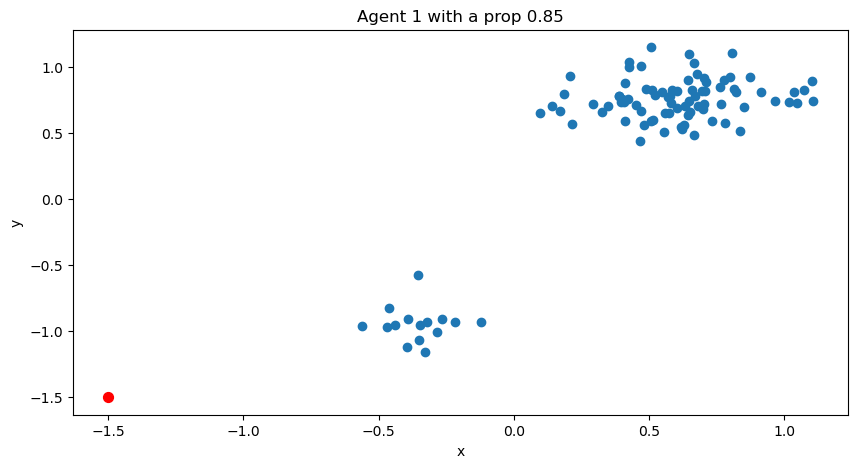

In [15]:
propAgents = data['propAgents']
agent1 = 'Agent 0'
plt.figure(figsize=(10, 5))
plt.plot(data[agent1][:, 0], data[agent1][:, 1], 'o')
plt.scatter(data['outlier'][0,0], data['outlier'][0,1], c='r', s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Agent 1 with a prop {propAgents[0]:.2f}')
plt.show()


#### Figure 2 - Sample of $\theta^S$

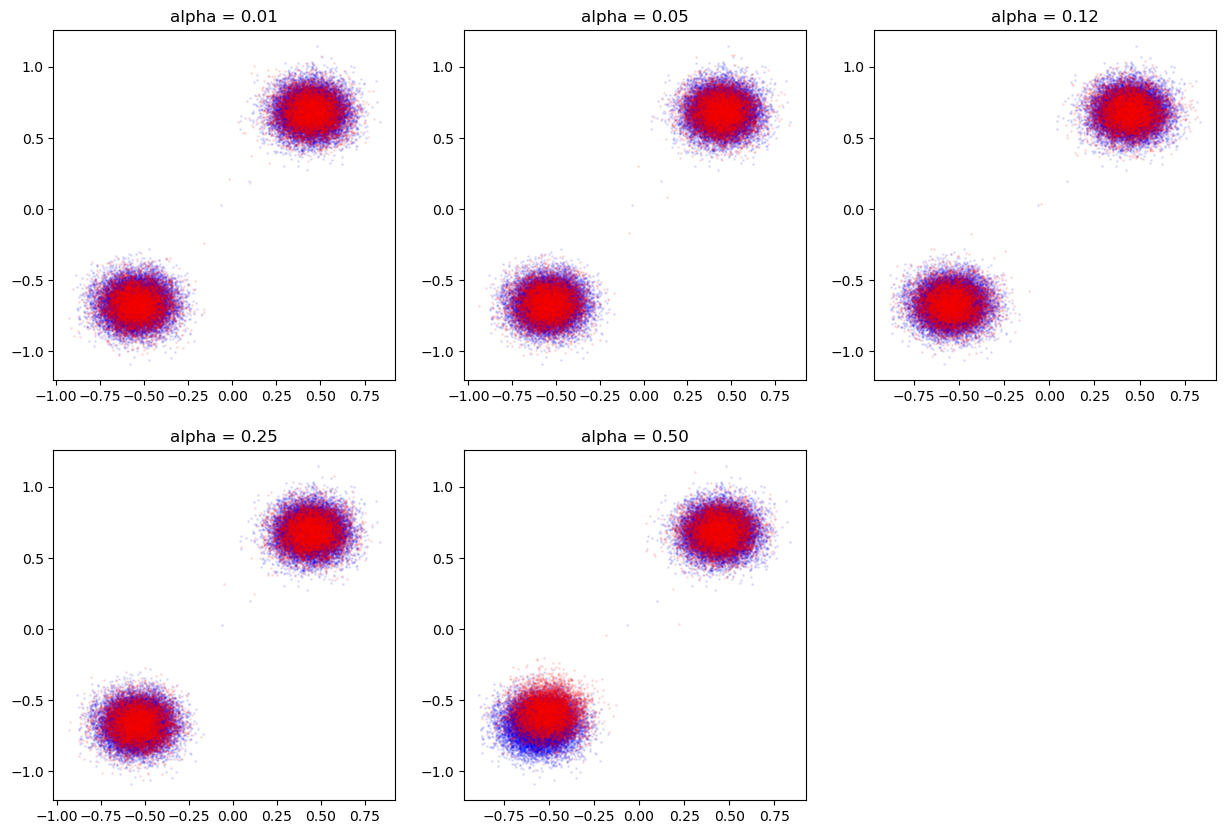

In [16]:
fig = plt.figure(figsize=(15,10))
for i in range(len(alphas)):
    plt.subplot(2,3,i+1)
    plt.scatter(thetaS1_evolution[:,0],thetaS1_evolution[:,1],label='thetaS1 outlier', s = 1,c = 'b', alpha = 0.1)
    plt.scatter(thetaS2_evolution[:,0],thetaS2_evolution[:,1],label='thetaS2 outlier', s = 1,c= 'b', alpha = 0.1)
    plt.scatter(thetaS2_evolution_alpha[i,:,0],thetaS2_evolution_alpha[i,:,1],s = 1,c= 'r',label='thetaS2 data',alpha = 0.1)
    plt.scatter(thetaS1_evolution_alpha[i,:,0],thetaS1_evolution_alpha[i,:,1],s = 1,c= 'r',label='thetaS1 data',alpha=0.1)

    plt.title(f'alpha = {alphas[i]:.2f}')

In [38]:
thetaA2_evolution_alpha.shape

(5, 8000, 10, 2)

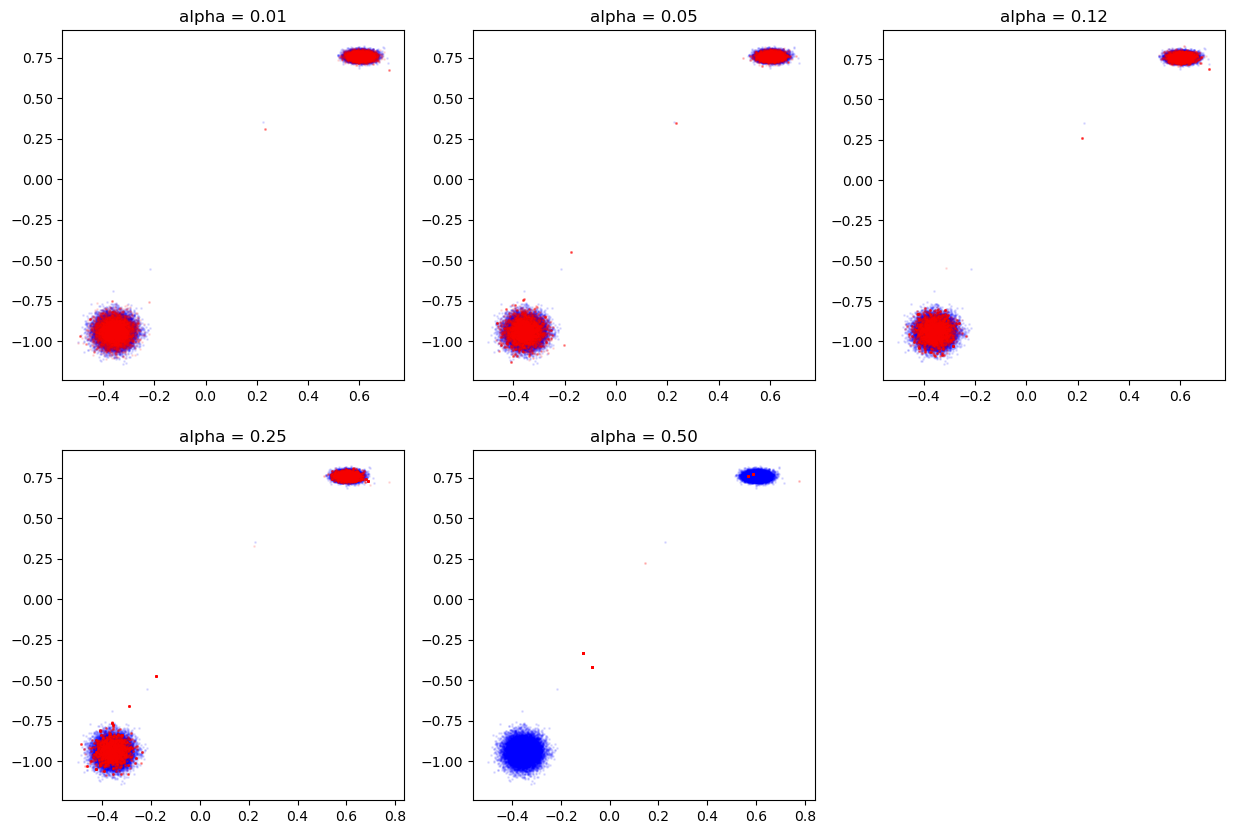

In [39]:
fig = plt.figure(figsize=(15,10))
for i in range(len(alphas)):
    plt.subplot(2,3,i+1)
    plt.scatter(thetaA1_evolution[:,0,0],thetaA1_evolution[:,0,1],label='thetaA1', s = 1,c = 'b', alpha = 0.1)
    plt.scatter(thetaA2_evolution[:,0,0],thetaA2_evolution[:,0,1],label='thetaA2', s = 1,c= 'b', alpha = 0.1)
    plt.scatter(thetaA2_evolution_alpha[i,:,0,0],thetaA2_evolution_alpha[i,:,0,1],s = 1,c= 'r',label='thetaA2 data',alpha = 0.1)
    plt.scatter(thetaA1_evolution_alpha[i,:,0,0],thetaA1_evolution_alpha[i,:,0,1],s = 1,c= 'r',label='thetaA1 data',alpha=0.1)

    plt.title(f'alpha = {alphas[i]:.2f}')

####  Compare the true server distribution and the one obtained with the noisy MH algorithm with an outlier on Agent 1

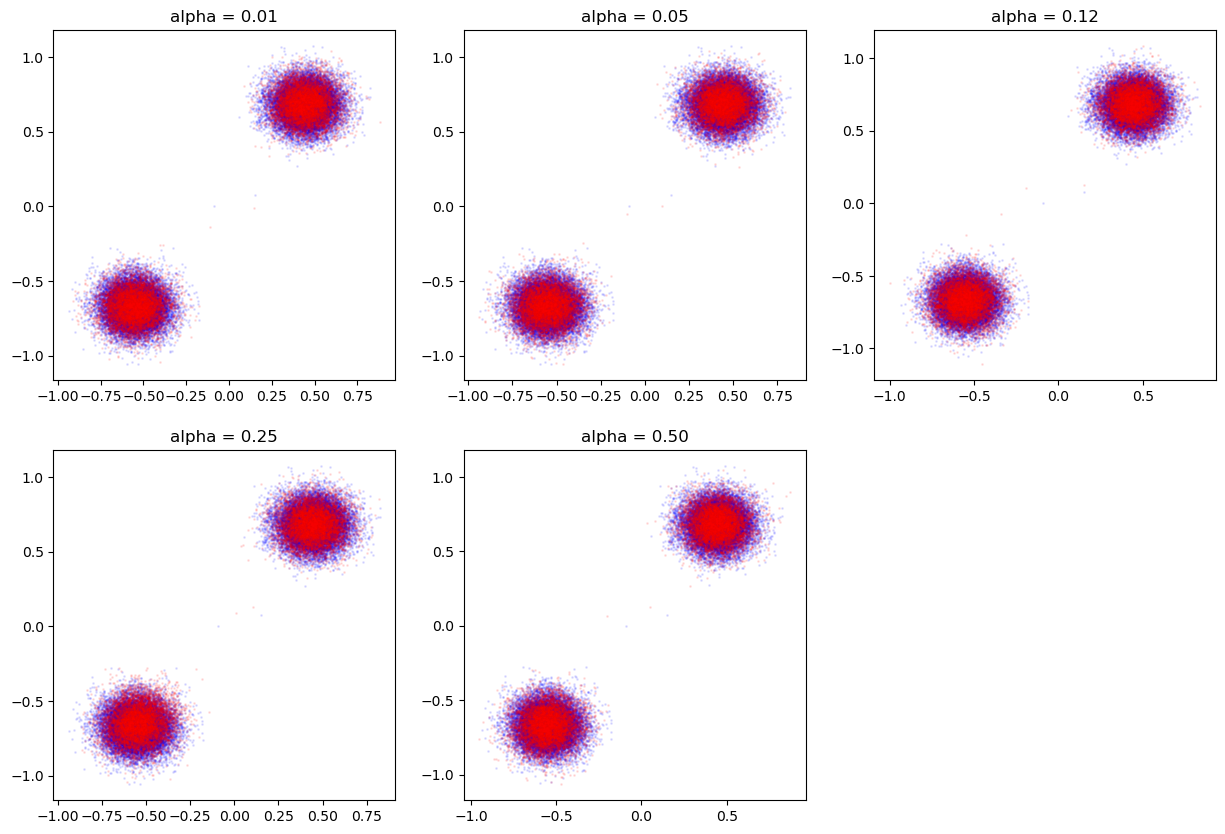

In [17]:
fig = plt.figure(figsize=(15,10))
for i in range(len(alphas)):
    plt.subplot(2,3,i+1)
    plt.scatter(thetaS1_evolution_outlier[:,0],thetaS1_evolution_outlier[:,1],label='thetaS1 outlier', s = 1,c = 'b', alpha = 0.1)
    plt.scatter(thetaS2_evolution_outlier[:,0],thetaS2_evolution_outlier[:,1],label='thetaS2 outlier', s = 1,c= 'b', alpha = 0.1)
    plt.scatter(thetaS2_evolution_alpha_outlier[i,:,0],thetaS2_evolution_alpha_outlier[i,:,1],s = 1,c= 'r',label='thetaS2 data',alpha = 0.1)
    plt.scatter(thetaS1_evolution_alpha_outlier[i,:,0],thetaS1_evolution_alpha_outlier[i,:,1],s = 1,c= 'r',label='thetaS1 data',alpha=0.1)

    plt.title(f'alpha = {alphas[i]:.2f}')

#### Compare the true agent distribution and the one obtained with the noisy MH algorithm with an outlier on this agent

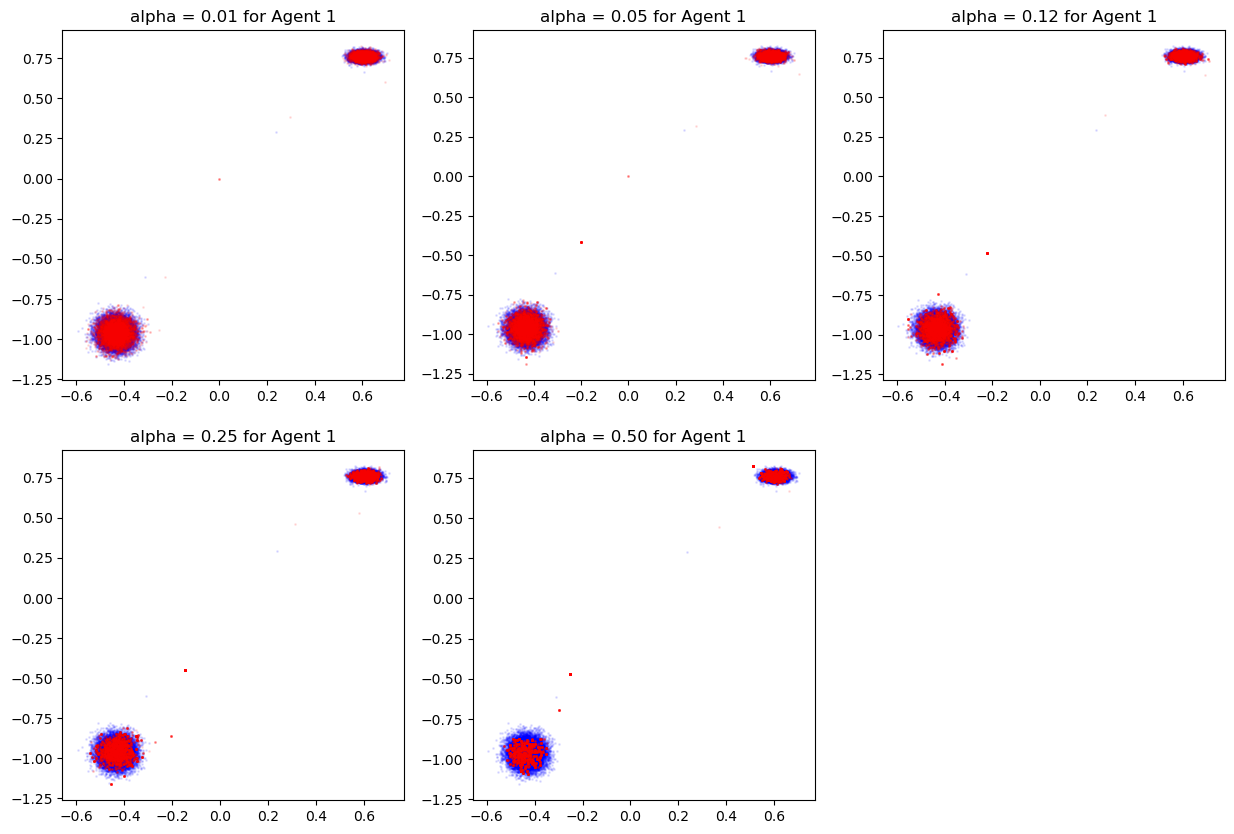

In [18]:
fig = plt.figure(figsize=(15,10))

for i in range(len(alphas)):
    plt.subplot(2,3,i+1)
    plt.scatter(thetaA1_evolution_outlier[:,0,0],thetaA1_evolution_outlier[ :,0,1],label='thetaA1 outlier', s = 1,c = 'b', alpha = 0.1)
    plt.scatter(thetaA2_evolution_outlier[:,0,0],thetaA2_evolution_outlier[ :,0,1],label='thetaA2 outlier', s = 1,c= 'b', alpha= 0.1)
    plt.scatter(thetaA1_evolution_alpha_outlier[i,:,0,0],thetaA1_evolution_alpha_outlier[i,:,0,1],s = 1,label='thetaA1 data',alpha=0.1, c= 'r')
    plt.scatter(thetaA2_evolution_alpha_outlier[i,:,0,0],thetaA2_evolution_alpha_outlier[i,:,0,1],s = 1,label='thetaA2 data',alpha = 0.1, c= 'r')
    plt.title(f'alpha = {alphas[i]:.2f} for Agent 1')

#### Compare the true agent distribution without an outlier and the one obtained with the noisy MH algorithm with an outlier on this agent

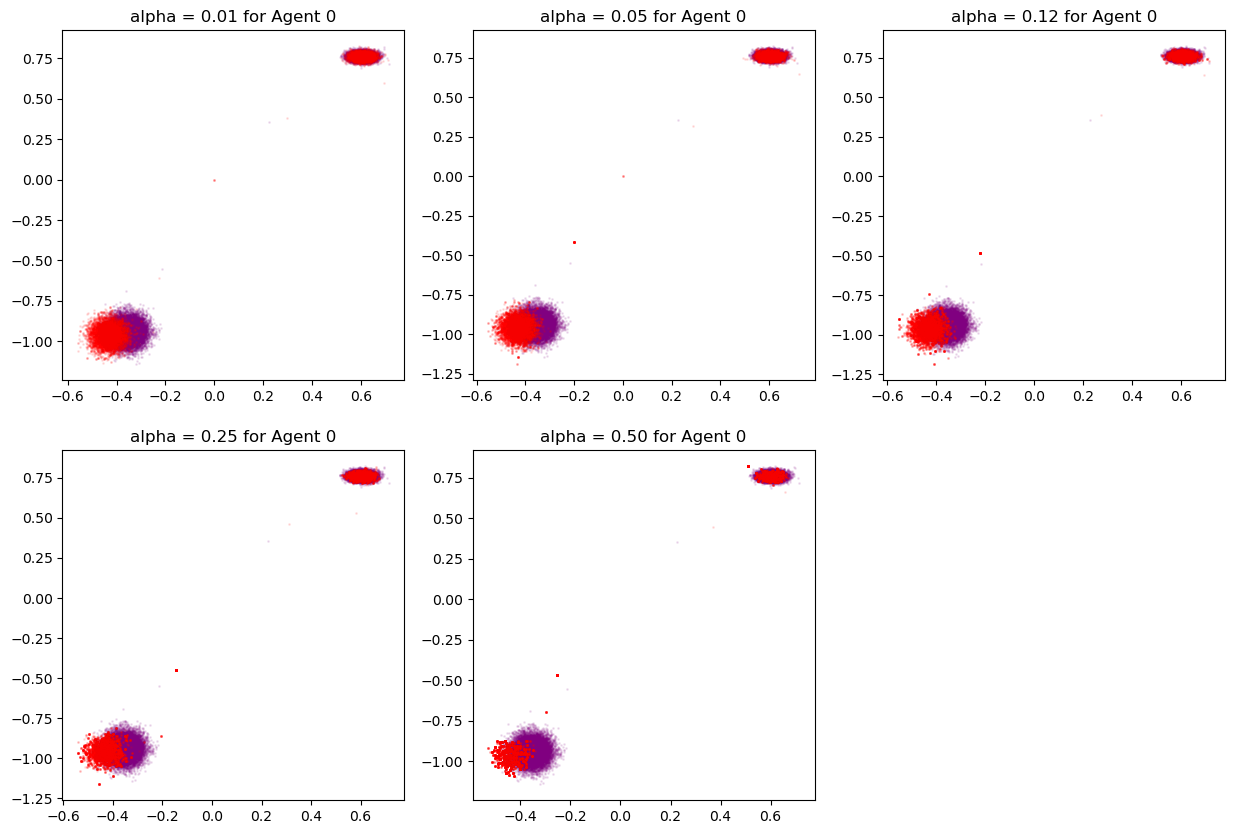

In [19]:
fig = plt.figure(figsize=(15,10))
for i in range(len(alphas)):
    plt.subplot(2,3,i+1)

    plt.scatter(thetaA1_evolution[:,0,0],thetaA1_evolution[:,0,1],label='thetaA1', s = 1,c = 'purple', alpha = 0.1)
    plt.scatter(thetaA2_evolution[:,0,0],thetaA2_evolution[:,0,1],label='thetaA2', s = 1,c= 'purple', alpha= 0.1)
    plt.scatter(thetaA1_evolution_alpha_outlier[i,:,0,0],thetaA1_evolution_alpha_outlier[i,:,0,1],s = 1,label='thetaA1 data',alpha=0.1, c= 'r')
    plt.scatter(thetaA2_evolution_alpha_outlier[i,:,0,0],thetaA2_evolution_alpha_outlier[i,:,0,1],s = 1,label='thetaA2 data',alpha = 0.1, c= 'r')

    plt.title(f'alpha = {alphas[i]:.2f} for Agent 0')

#### Figure 3 - Plot of the marginales of $\theta^1$ without any outlier

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x1000 with 0 Axes>

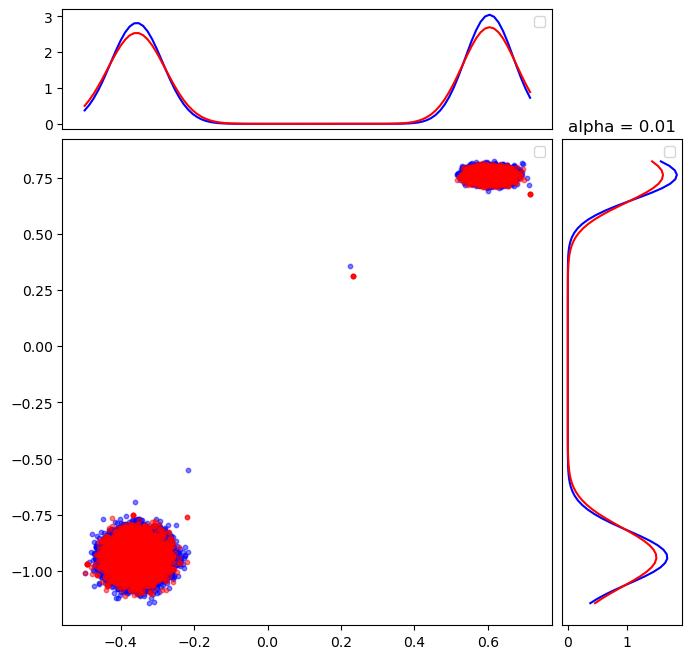

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


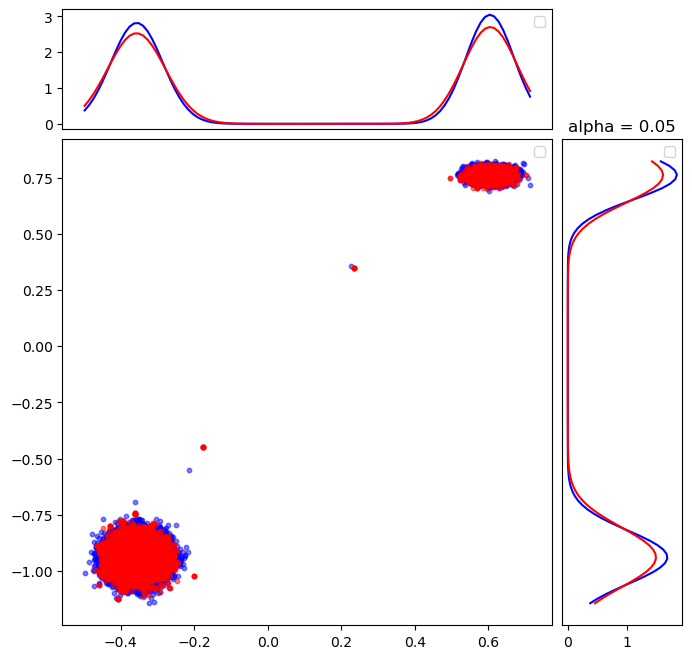

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


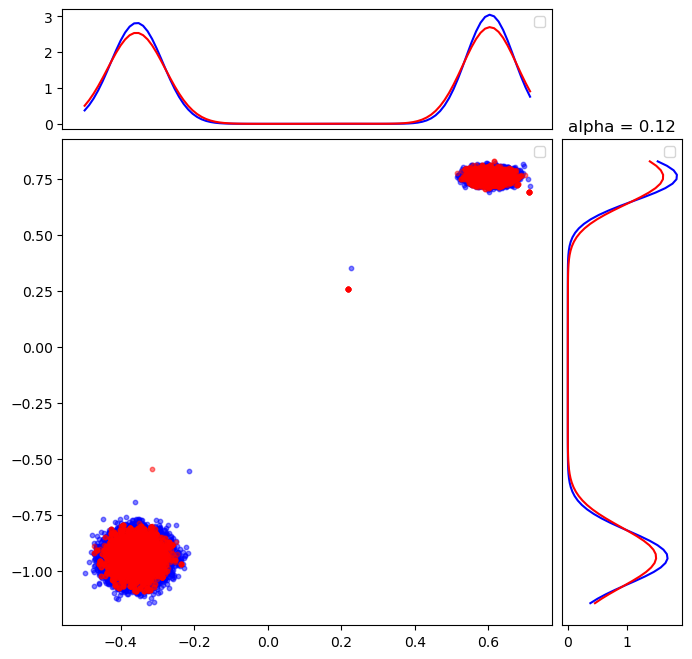

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


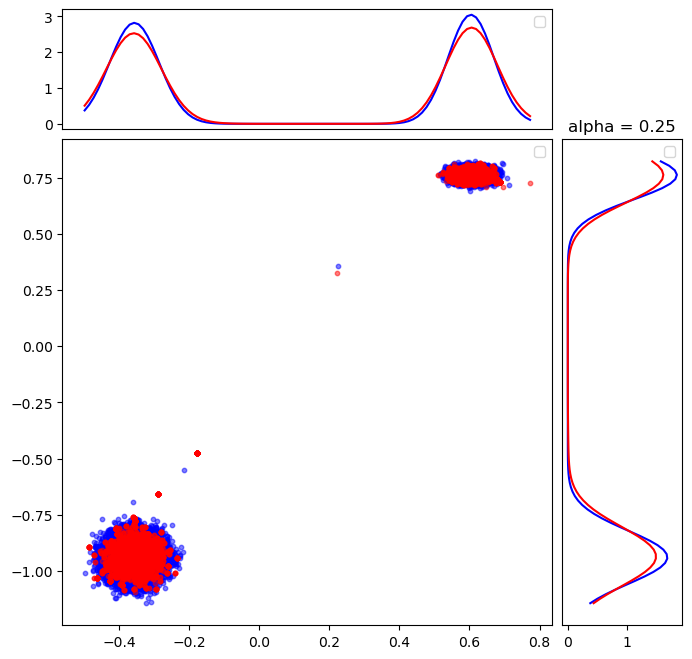

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


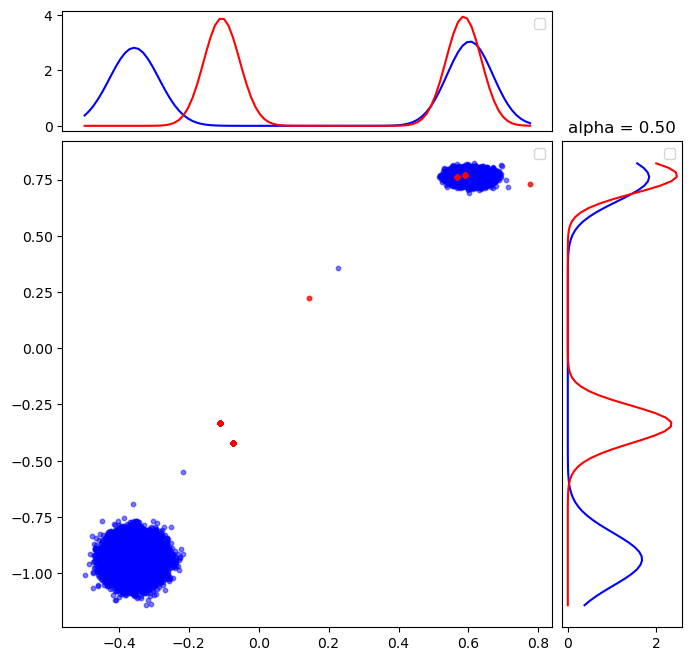

In [34]:
fig = plt.figure(figsize=(15,10))
for i,a in enumerate(alphas):
    data1 = np.concatenate([thetaA1_evolution[:,0,:], thetaA2_evolution[:,0,:]], axis = 0)
    data2 = np.concatenate([thetaA1_evolution_alpha[i,:,0,:], thetaA2_evolution_alpha[i,:,0,:]], axis = 0)
    plot_marginale(data1, data2, alphas[i])

#### Figure 5 - Plot of the marginales of $\theta^1$ with any outlier

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1500x1000 with 0 Axes>

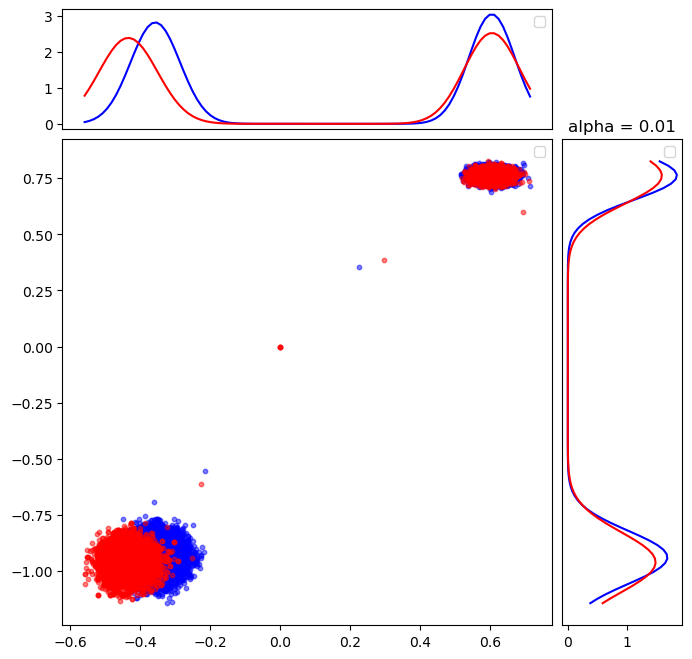

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


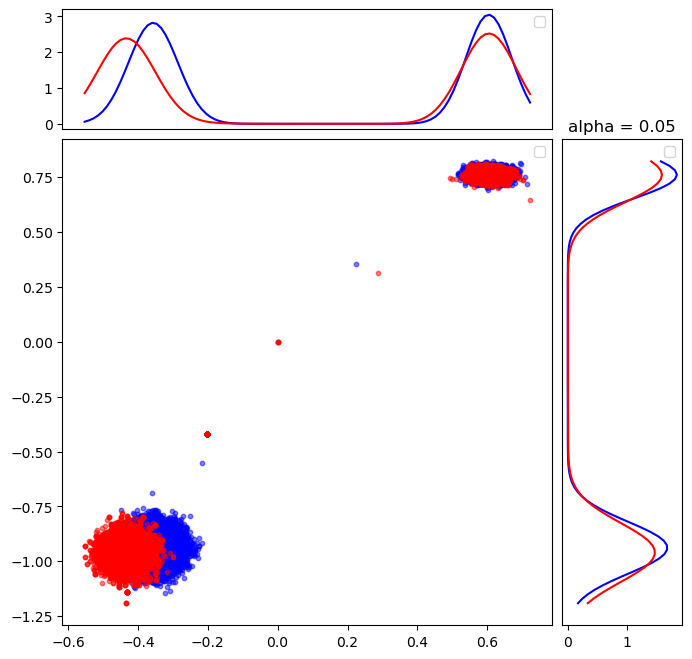

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


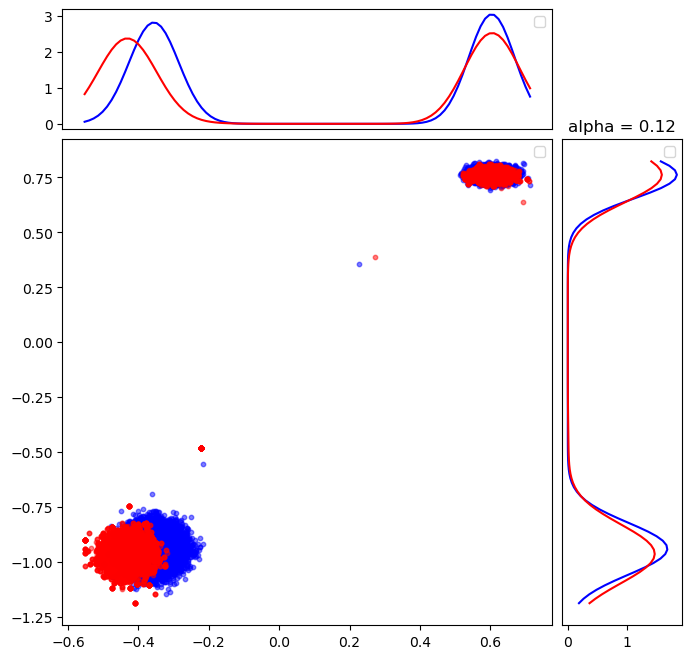

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


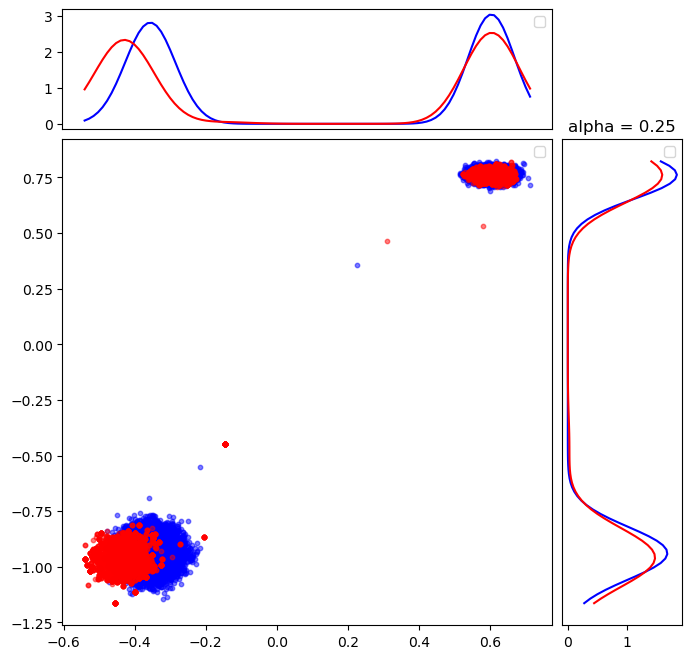

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


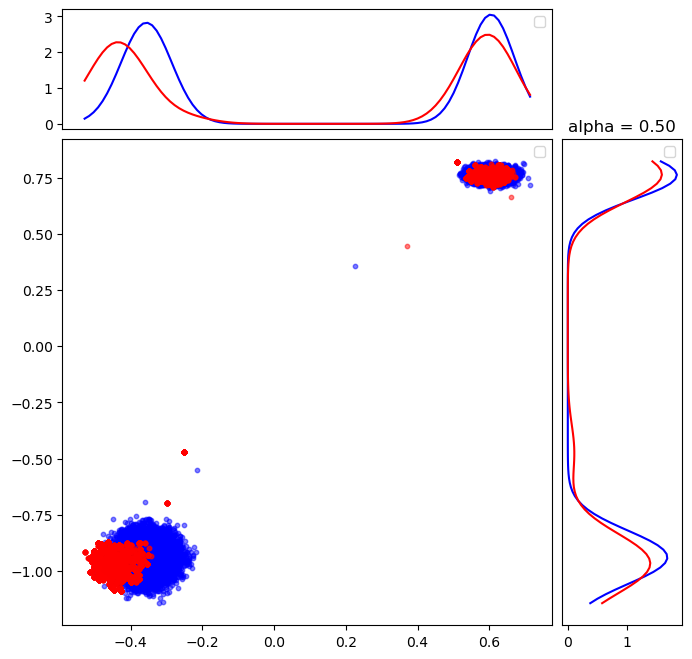

In [21]:
fig = plt.figure(figsize=(15,10))
for i,a in enumerate(alphas):
    data1 = np.concatenate([thetaA1_evolution[:,0,:], thetaA2_evolution[:,0,:]], axis = 0)
    data2 = np.concatenate([thetaA1_evolution_alpha_outlier[i,:,0,:], thetaA2_evolution_alpha_outlier[i,:,0,:]], axis = 0)
    plot_marginale(data1, data2, alphas[i])

#### Figure 6 - Acceptances Rates evolution

In [22]:
acceptance_rate_A1 = acceptance_rate(thetaA1_evolution_alpha)
acceptance_rate_A2 = acceptance_rate(thetaA2_evolution_alpha)
acceptance_rate_A1_outlier = acceptance_rate(thetaA1_evolution_alpha_outlier)
acceptance_rate_A2_outlier = acceptance_rate(thetaA2_evolution_alpha_outlier)

Text(0.5, 1.0, 'For agent 0')

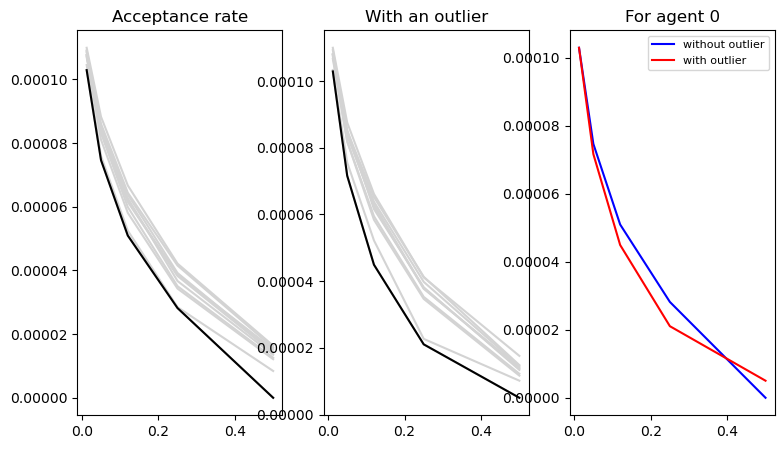

In [23]:
plt.subplots(1,3,figsize = (9,5))
plt.subplot(1,3,1)
plt.plot(alphas.tolist(),acceptance_rate_A1/nRounds, c= 'lightgrey')
plt.plot(alphas.tolist(),acceptance_rate_A1[:,0]/nRounds, c = 'black')
plt.title('Acceptance rate')
plt.subplot(1,3,2)
plt.plot(alphas,acceptance_rate_A1_outlier/nRounds, c= 'lightgrey')
plt.plot(alphas,acceptance_rate_A1_outlier[:,0]/nRounds, c = 'black')
plt.title('With an outlier')

plt.subplot(1,3,3)
plt.plot(alphas.tolist(),acceptance_rate_A1[:,0]/nRounds, c = 'b', label = 'without outlier')
plt.plot(alphas,acceptance_rate_A1_outlier[:,0]/nRounds, c = 'r', label = 'with outlier')
plt.legend()
plt.legend(fontsize = 8)
plt.title('For agent 0')

#### KL evolutions across the iterations for different $\alpha$, for multiple simulations 

We now calculate the symmetric KL distance between the true posterior (in the theta\_evolution variables) and the simulation of the noisy MH algorithm (in the theta\_evolution\_alpha variables). We do this for each value of alpha. 
We also compare the true distribution with the presence of an outlier and the true distribution without it. 

In [25]:
# Sample data
KL_points = np.linspace(nBurn, nRounds, nPoints, dtype=int)
nSimulations= 50
all_dist_to_cvg = np.zeros((nSimulations, len(alphas) + 1 ,nPoints, 2*nAgents+2))
all_dist_to_cvg_outlier = np.zeros((nSimulations,len(alphas)+1, nPoints, 2*nAgents+2))
for i in range(nSimulations):
    ################################
    ### Our simulation file are from 50 to 99
    ### Adapt the following line for it
    index = i + nSimulations
    #################################
    all_dist_to_cvg[i,:,:,:] = np.load(f'./results/simulation_{index}/dist_to_cvg.npy')
    all_dist_to_cvg_outlier[i,:,:,:] = np.load(f'./results/simulation_{index}/dist_to_cvg_outlier.npy')

#### Figure 4 - KL evolution for different \alphas

Text(0.5, 1.0, 'thetaS2')

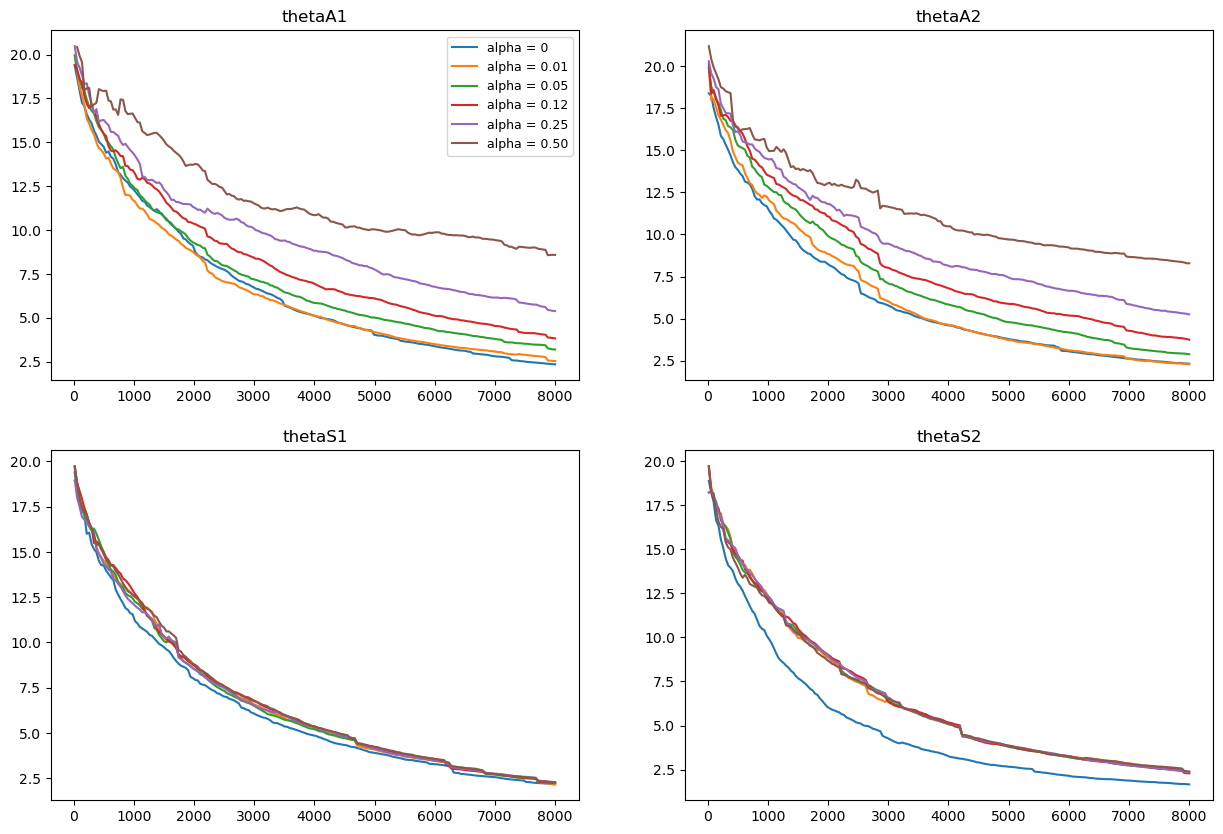

In [26]:
simulation = 0
plt.subplots(2,2,figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(KL_points,all_dist_to_cvg[simulation,:,:,0].T, label=['alpha = 0'] + [f'alpha = {alpha:.2f}' for alpha in alphas])
plt.legend(fontsize = 9)
plt.title('thetaA1')
plt.subplot(2,2,2)
plt.plot(KL_points,all_dist_to_cvg[simulation,:,:,nAgents].T, label=['alpha = 0'] + [f'alpha = {alpha:.2f}' for alpha in alphas])
plt.title('thetaA2')
plt.subplot(2,2,3)
plt.plot(KL_points,all_dist_to_cvg[simulation,:,:,2*nAgents].T, label=['alpha = 0'] + [f'alpha = {alpha:.2f}' for alpha in alphas])
plt.title('thetaS1')
plt.subplot(2,2,4)
plt.plot(KL_points,all_dist_to_cvg[simulation,:,:,1+ 2*nAgents].T, label=['alpha = 0'] + [f'alpha = {alpha:.2f}' for alpha in alphas])
plt.title('thetaS2')

#### Figures 8/9/10/11

Text(0.5, 1.0, 'alpha = 0')

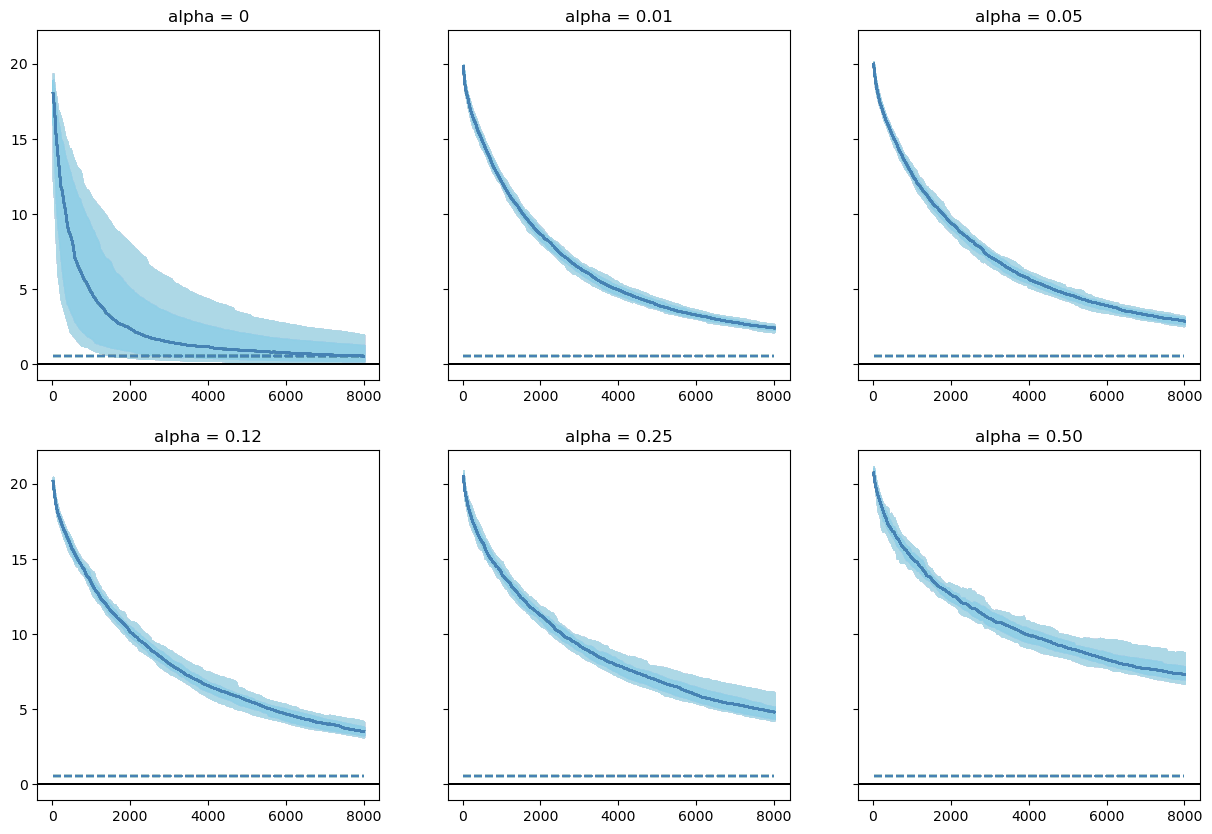

In [27]:
fig,axes = plt.subplots(2,3,figsize = (15,10), sharey = True)
parameter = nAgents
quantile = np.nanpercentile(all_dist_to_cvg[:,0,-1,:],50, axis=0)[parameter]* np.ones(nPoints)


for a in range(3):
    quantiles = np.nanpercentile(all_dist_to_cvg[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[0,a].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[0,a].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[0,a].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[0,a].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[0,a].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[0, a].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

        # plt.legend()

for j in range(3):
    a = 3 + j
    quantiles = np.nanpercentile(all_dist_to_cvg[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[1,j].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[1,j].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[1,j].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[1,j].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[1,j].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[1, j].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

axes[0,0].set_title(f'alpha = 0')


Text(0.5, 1.0, 'alpha = 0')

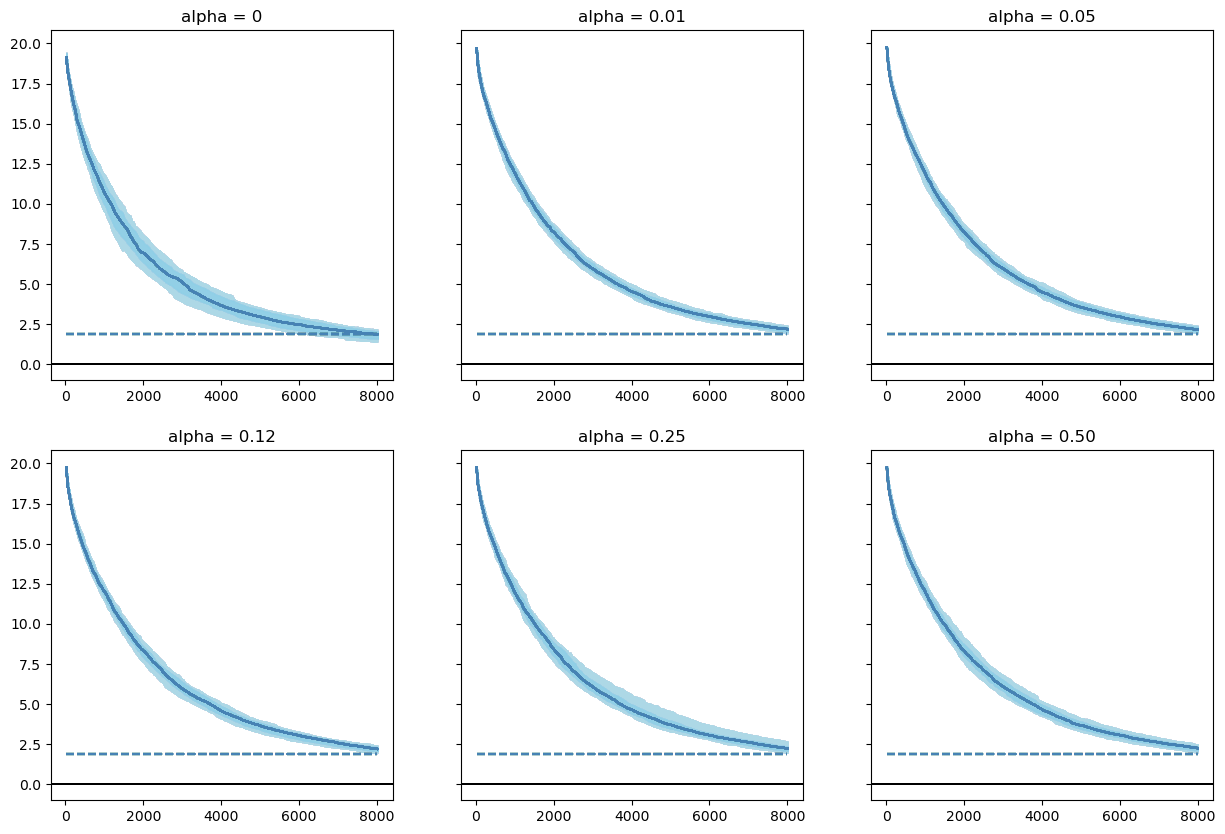

In [28]:
fig,axes = plt.subplots(2,3,figsize = (15,10), sharey = True)
parameter = 2*nAgents +1
quantile = np.nanpercentile(all_dist_to_cvg[:,0,-1,:],50, axis=0)[parameter]* np.ones(nPoints)

for a in range(3):
    quantiles = np.nanpercentile(all_dist_to_cvg[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[0,a].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[0,a].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[0,a].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[0,a].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[0, a].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

        axes[0,a].set_title(f'alpha = {alphas[a-1]:.2f}')
        # plt.legend()

for j in range(3):
    a = 3 + j
    quantiles = np.nanpercentile(all_dist_to_cvg[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[1,j].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[1,j].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[1,j].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[1,j].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[1,j].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[1, j].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

axes[0,0].set_title(f'alpha = 0')

#### KL evolutions across the iterations for different $\alpha$, for multiple simulations, with an outlier

We add an outlier on the $2^{nd}$ mode of Agent 1.

Text(0.5, 1.0, 'alpha = 0')

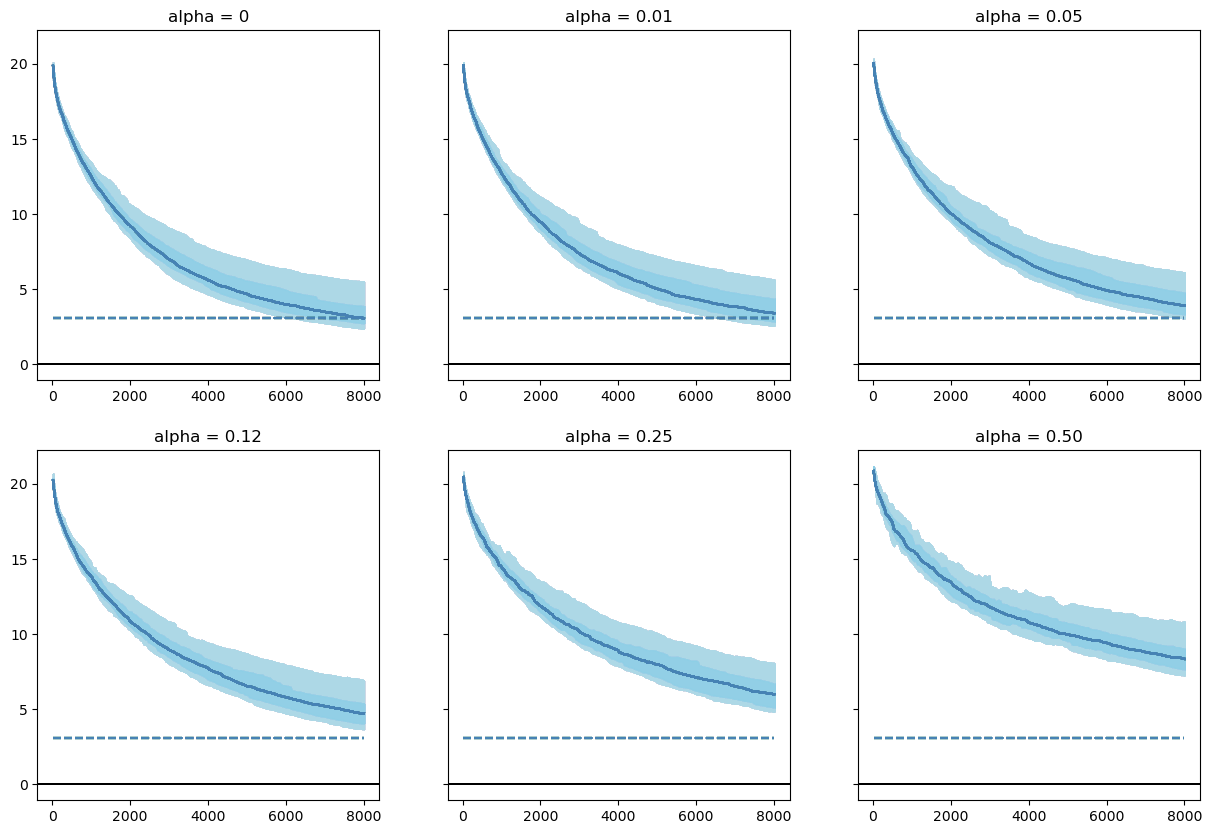

In [29]:
fig,axes = plt.subplots(2,3,figsize = (15,10), sharey = True)
parameter = nAgents
quantile = np.nanpercentile(all_dist_to_cvg_outlier[:,0,-1,:],50, axis=0)[parameter]* np.ones(nPoints)
for a in range(3):
    quantiles = np.nanpercentile(all_dist_to_cvg_outlier[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[0,a].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[0,a].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[0,a].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[0,a].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[0,a].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[0, a].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

        # plt.legend()

for j in range(3):
    a = 3 + j
    quantiles = np.nanpercentile(all_dist_to_cvg_outlier[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[1,j].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[1,j].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[1,j].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[1,j].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[1,j].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[1, j].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')
axes[0,0].set_title(f'alpha = 0')


Text(0.5, 1.0, 'alpha = 0')

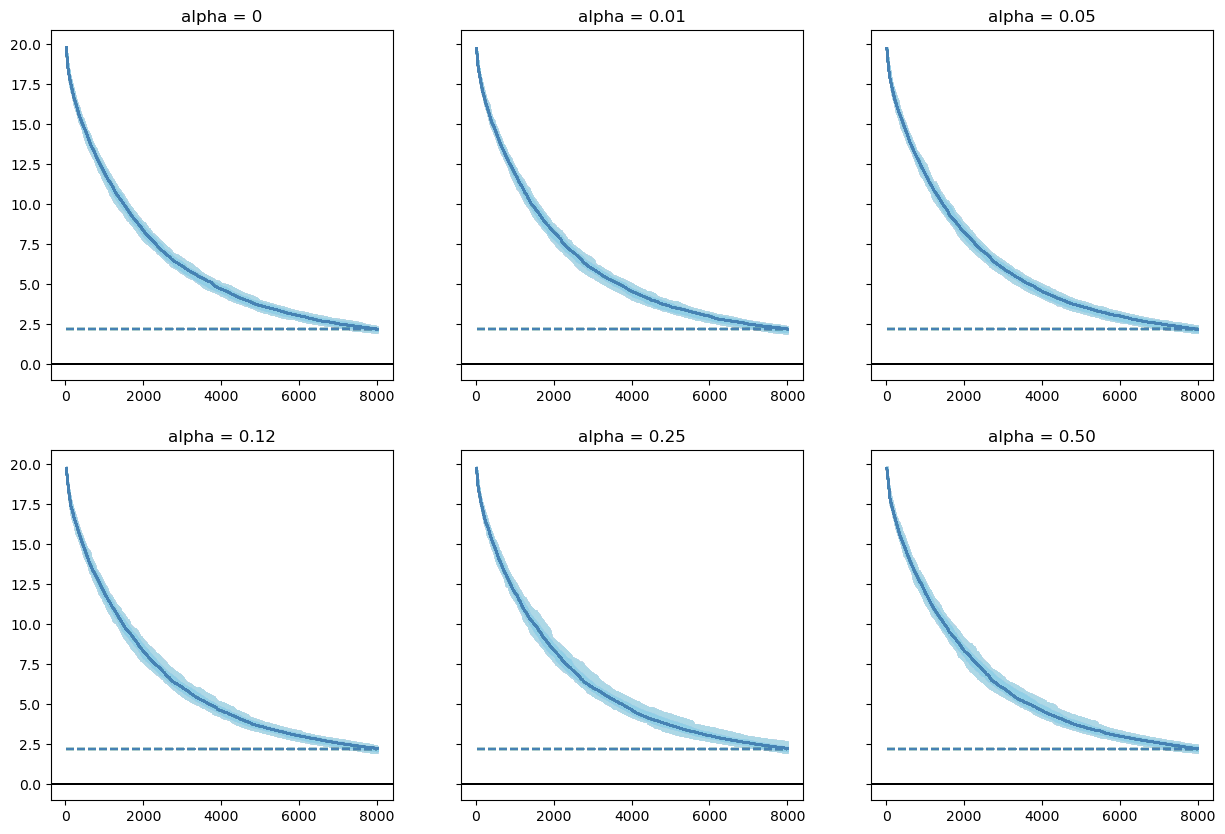

In [30]:
fig,axes = plt.subplots(2,3,figsize = (15,10), sharey = True)
parameter = 2*nAgents +1
quantile = np.nanpercentile(all_dist_to_cvg_outlier[:,0,-1,:],50, axis=0)[parameter]* np.ones(nPoints)

for a in range(3):
    quantiles = np.nanpercentile(all_dist_to_cvg_outlier[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[0,a].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[0,a].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[0,a].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[0,a].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[0,a].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[0,a].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

        # plt.legend()

for j in range(3):
    a = 3 + j
    quantiles = np.nanpercentile(all_dist_to_cvg_outlier[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[1,j].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[1,j].plot(KL_points, quantile, linestyle = '--', c = 'steelblue', alpha = 0.2)
        axes[1,j].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[1,j].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[1,j].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[1, j].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

axes[0,0].set_title(f'alpha = 0')


#### Let's compare both 

Text(0.5, 1.0, 'alpha = 0')

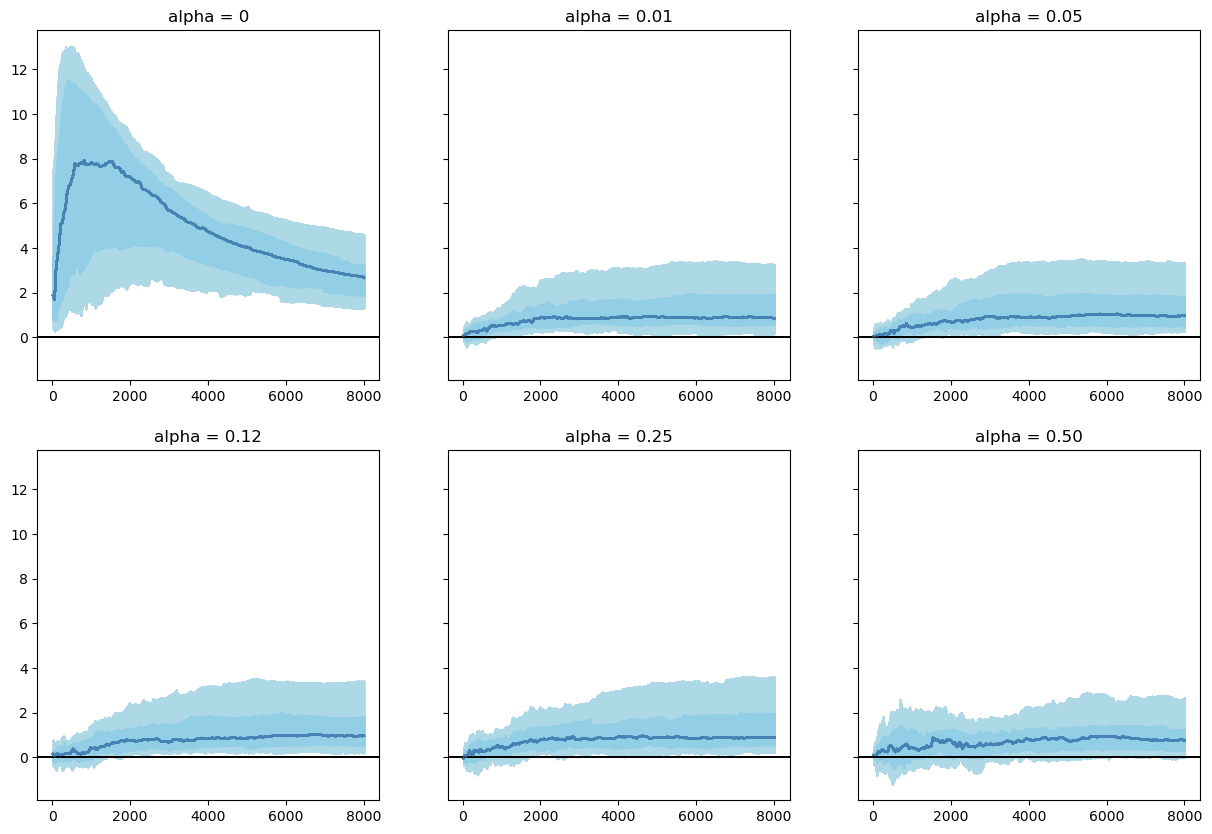

In [32]:
fig,axes = plt.subplots(2,3,figsize = (15,10), sharey = True)
parameter = nAgents

diff = all_dist_to_cvg_outlier - all_dist_to_cvg

for a in range(3):
    quantiles = np.nanpercentile(diff[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[0,a].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[0,a].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[0,a].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[0,a].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[0,a].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

        # plt.legend()

for j in range(3):
    a = 3 + j
    quantiles = np.nanpercentile(diff[:,a,:,:], [10,25, 50, 75, 90], axis=0)
    for k in range(nSimulations):
        axes[1,j].plot(KL_points, quantiles[2,:,parameter], c = 'steelblue', alpha = 0.5, label = 'median')
        axes[1,j].fill_between(KL_points, quantiles[1,:,parameter], quantiles[3,:,parameter], color = 'skyblue', alpha = 0.2, label = 'interquartile range')
        axes[1,j].fill_between(KL_points, quantiles[0,:,parameter], quantiles[4,:,parameter], color = 'lightblue', alpha = 0.1, label = '10-90% quantile range')
        axes[1,j].set_title(f'alpha = {alphas[a-1]:.2f}')
        axes[1, j].axhline(y=0, color='black', linestyle='solid', linewidth=0.3, label='y=0 intercept')

axes[0,0].set_title(f'alpha = 0')
